In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# set number of classes

In [4]:
NUM_CLASSES = 5

# load training data

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

#  build model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [10]:
# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
21/26 [=======================>......] - ETA: 0s - loss: 1.6795 - accuracy: 0.2016 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
26/26 [==============================] - 1s 16ms/step - loss: 1.6718 - accuracy: 0.2027 - val_loss: 1.5964 - val_accuracy: 0.2179
Epoch 2/1000
19/26 [====================>.........] - ETA: 0s - loss: 1.6294 - accuracy: 0.2266
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 1.6227 - accuracy: 0.2273 - val_loss: 1.5874 - val_accuracy: 0.2291
Epoch 3/1000
19/26 [====================>.........] - ETA: 0s - loss: 1.5987 - accuracy: 0.2368
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
26/26 [==============================] - 0s 6ms/step - loss: 1.5976 - accuracy: 0.2394 - val_loss: 1.5744 - val_accuracy: 0.2942
Epoch 4/1000
18/26 [===================>..........] - ETA: 0s - loss: 1.5862 - accuracy: 0.2539

In [13]:
# model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 [==============================] - 0s 2ms/step - loss: 1.0215 - accuracy: 0.5680


In [14]:
# load the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# reasoning test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 91ms/step
[0.28042144 0.09126449 0.21681687 0.26116785 0.15032926]
0


# Confusion Matrix

34/34 [==============================] - 0s 4ms/step


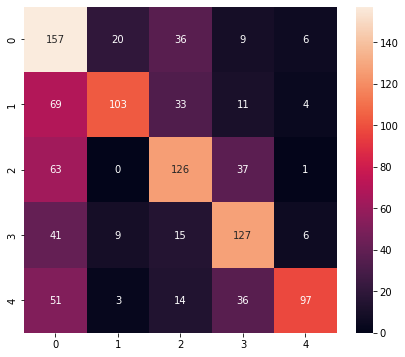

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.69      0.52       228
           1       0.76      0.47      0.58       220
           2       0.56      0.56      0.56       227
           3       0.58      0.64      0.61       198
           4       0.85      0.48      0.62       201

    accuracy                           0.57      1074
   macro avg       0.63      0.57      0.58      1074
weighted avg       0.63      0.57      0.57      1074



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# save as inference-only model
model.save(model_save_path, include_optimizer=False)

In [19]:
# transform the model (quantization)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpuk78dry2\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpuk78dry2\assets


6588

# reasoning test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# perform inference
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 1.01 ms


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.28042147 0.09126449 0.21681687 0.26116782 0.15032928]
0
